In [25]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import os, glob
import numpy as np
from tqdm import tqdm
from PIL import Image

IMG_SIZE = 224

def loadImages(path):
    images, labels, names = [], [], []
    for c in ['Non_Grassland', 'Grassland']:
        for file in tqdm(glob.glob(os.path.join(path, c, "*.jpg"))):
            img = Image.open(file)
            img = img.resize((IMG_SIZE,IMG_SIZE), Image.ANTIALIAS)
            images.append(np.asarray(img))
            labels.append(c)
            names.append(file)
    images = np.array(images)
    labels = np.array(labels)
    names = np.array(names)
    return images, labels, names

def extract_features(img, model):
    # exctract reprasentation of an image using a pretrained VGG model
    reshaped_img = img.reshape(1,IMG_SIZE,IMG_SIZE,3)
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# function that lets you view a cluster (based on identifier)
def view_cluster(cluster, n_clusters, groups, samples=4):
        print("Cluster {0}/{1}".format(cluster+1, n_clusters))
        # gets the list of filenames for a cluster
        files = groups[cluster]
        non_grass = sum([1 for x in files if 'Non_Grassland' in x])

        print("Cluster size {}. Grasslands: {} Non Grassland: {} ".format(len(files), len(files) - non_grass, non_grass))
        for i in range(0, len(files) - 2, samples ** 2):
            files_sample = files[i:(samples ** 2 + i)]
            plt.figure(figsize=(25, 25))
            for index, file in enumerate(files_sample):
                plt.subplot(samples, samples, index + 1);
                img = load_img(file)
                img = np.array(img)
                plt.imshow(img)
                plt.title(file.split('/')[-2][:5])
                plt.axis('off')
            plt.show()
            # yes / no / quit
            ans = input("Do you want to plot more of this class? (y)es, (n)o, (q)uit: ")
            while not (ans.lower().startswith('y') or ans.lower().startswith('n') or ans.lower().startswith('q')):
                ans = input("Do you want to plot more of this class? (y)es, (n)o, (q)uit: ")
            if ans.lower()[0] in ['n', 'q']:
                return ans.lower()[0]
        return 'y'


In [3]:
path = '/nfs/data2/IVMSP_callisto/Images/final/'
images, labels, names = loadImages(path)

model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40220/40220 [04:55<00:00, 136.00it/s]
2022-04-14 14:09:11.453356: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 14:09:11.698500: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2298665000 Hz
2022-04-14 14:09:11.701255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563d0855fec0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-14 14:09:11.701329: I tensorflow/compiler/xla/servic

In [4]:
data = {}
ids = [x.split('/')[-1].split('.')[0] for x in names]
p = "/nfs/data2/IVMSP_callisto/Images/final/features.pkl"

for img, name in tqdm(zip(images, ids)):
    feat = extract_features(img,model)
    data[name] = feat

filenames = np.array(list(data.keys()))
features = np.array(list(data.values()))
features = features.reshape(-1,4096)

45581it [2:29:40,  5.08it/s]


In [8]:
pca = PCA(n_components=100, random_state=420)
x = pca.fit_transform(features)

kmeans = KMeans(n_clusters=200, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=200, random_state=22)

In [13]:
groups = {}
for file, cluster in zip(names, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

n_clusters = np.unique(kmeans.labels_).shape[0]
good_clusters = []
grass_clusters = []
non_grass_clusters = []


Cluster 200/200
Cluster size 118. Grasslands: 114 Non Grassland: 4 


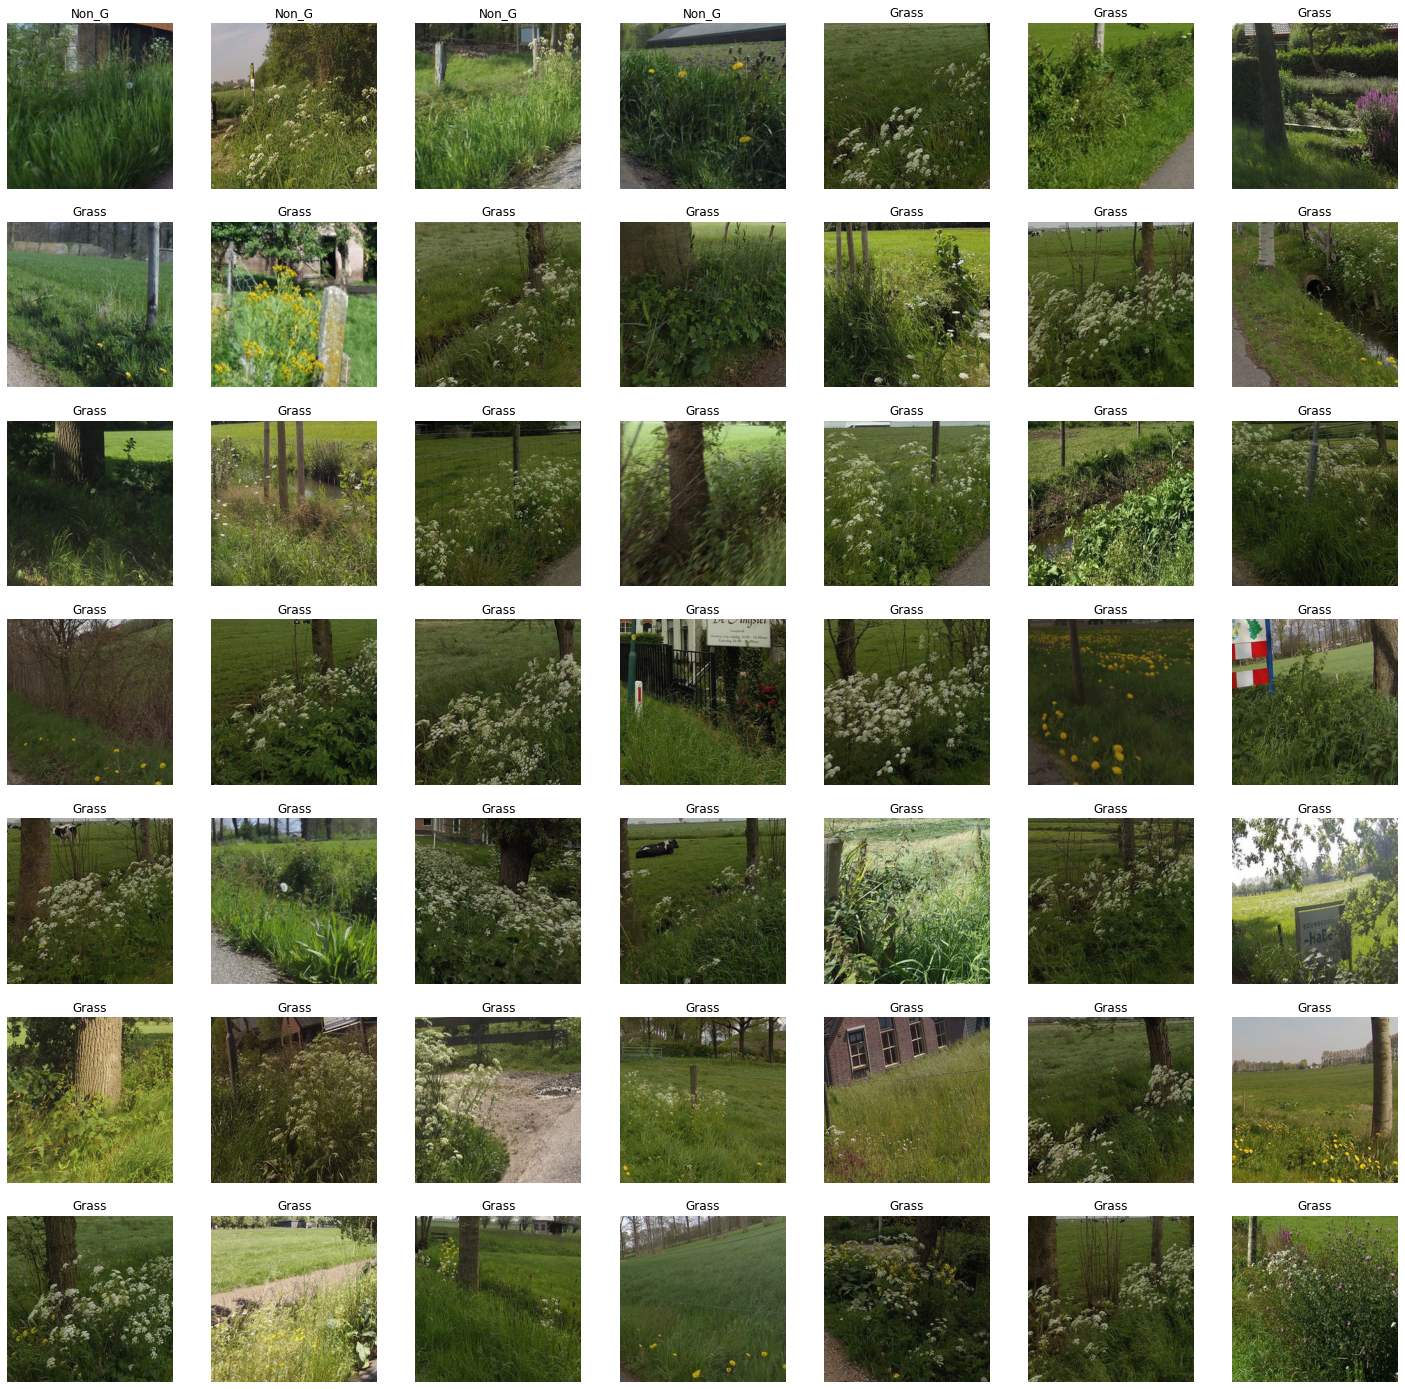

Do you want to plot more of this class? (y)es, (n)o, (q)uit: n
Do you want to keep this cluster? (y)es, (n)o, (1)class only, (q)uit: n


In [26]:
from IPython.display import clear_output

for cluster in np.unique(kmeans.labels_):

    clear_output(wait=True)
    resp = view_cluster(cluster, n_clusters, groups, samples=7)
    if resp == 'q':
        break

    ans = input("Do you want to keep this cluster? (y)es, (n)o, (1)class only, (q)uit: ")
    while not (ans.lower().startswith('y') or ans.lower().startswith('n')
               or ans.lower().startswith('q') or ans.lower().startswith('1')):
        ans = input("Do you want to keep this cluster? (y)es, (n)o, (1)class only, (q)uit: ")
    if ans.lower()[0] == 'y':
        good_clusters.append(cluster)
    elif ans.lower()[0] == '1':
        ans = input("Do you want to keep only Grasslands? (y)es, (n)o: ")
        if ans.lower()[0] == 'y':
            grass_clusters.append(cluster)
        else:
            non_grass_clusters.append(cluster)
    elif ans.lower()[0] == 'q':
        break


In [28]:
good_images = []

# Add images of the selected clusters for both classes
for element in np.unique(kmeans.labels_):
    if element in good_clusters:
        good_images.extend(groups[element])
        
# Add images of the selected clusters for Non Grassland class
for element in non_grass_clusters:
    good_images.extend([x for x in groups[element] if 'Non_Grassland' in x])
    
# Add images of the selected clusters for Grassland class
for element in grass_clusters:
    good_images.extend([x for x in groups[element] if 'Non_Grassland' not in x])
    
# Delete images
for img in names:
    if img not in good_images:
        os.remove(img)

In [41]:
grass = glob.glob(path+'Grassland/*')
nongrass = glob.glob(path+'Non_Grassland/*')

In [42]:
# Split to train and test set
grass_train, grass_test = train_test_split(grass, test_size=0.2, random_state=420)
nongrass_train, nongrass_test = train_test_split(nongrass, test_size=0.2, random_state=420)

In [47]:
# Create new directories
os.mkdir(path+'train/')
os.mkdir(path+'train/Grassland')
os.mkdir(path+'train/Non_Grassland')
os.mkdir(path+'test/')
os.mkdir(path+'test/Grassland')
os.mkdir(path+'test/Non_Grassland')

In [54]:
# Separate images to training and test directories

for source in grass_train:
    destination = source.replace('Grassland', 'train/Grassland')
    os.replace(source, destination)
    
for source in nongrass_train:
    destination = source.replace('Non_Grassland', 'train/Non_Grassland')
    os.replace(source, destination)
    
for source in grass_test:
    destination = source.replace('Grassland', 'test/Grassland')
    os.replace(source, destination)
    
for source in nongrass_test:
    destination = source.replace('Non_Grassland', 'test/Non_Grassland')
    os.replace(source, destination)
    
os.chdir(path)
os.rmdir('Grassland')
os.rmdir('Non_Grassland')

In [73]:
grass = [x for x in good_images if 'Non' not in x]
nongrass = [x for x in good_images if 'Non' in x]

In [81]:
grass_train, grass_test = train_test_split(grass, test_size=0.2, random_state=420)
nongrass_train, nongrass_test = train_test_split(nongrass, test_size=0.2, random_state=420)

for source in grass_train:
    destination = source.replace('Grassland', 'train/Grassland')
    os.replace(source, destination)
    
for source in nongrass_train:
    destination = source.replace('Non_Grassland', 'train/Non_Grassland')
    os.replace(source, destination)
    
for source in grass_test:
    destination = source.replace('Grassland', 'test/Grassland')
    os.replace(source, destination)
    
for source in nongrass_test:
    destination = source.replace('Non_Grassland', 'test/Non_Grassland')
    os.replace(source, destination)